# **Trabajo Práctico N° 1 - Aprendizaje Automático II - 2024**

### **Redes Densas y Convolucionales**  
**PROBLEMA 3**

---
**Alumnos:**


*   **Fontana Gustavo**
*   **Leguiza Claudia**



## **Librerías**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import zipfile
import json
import tensorflow as tf
import gdown
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from keras.layers import Input, RandomFlip, BatchNormalization, Flatten, Dropout, RandomTranslation, RandomContrast
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling, Add
from tensorflow.python.keras.callbacks import EarlyStopping
from PIL import Image
from tensorflow.keras.models import load_model

## **Configuración inicial**

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


## **Carga del dataset**

In [ ]:
# Descargar el archivo
file_id = '1-OqG2pqnOx8xySUsvG8SQtjUbzWlRtyG'
destination = '/content/dataset.zip'

gdown.download(f'https://drive.google.com/uc?id={file_id}', destination, quiet=False)

# Descomprimir y guardar en el entorno
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [14]:
# Directorio de los datos
TRAIN_DIRECTORY = "/content/dataset/seg_train/seg_train"
TEST_DIRECTORY = "/content/dataset/seg_test/seg_test"
PRED_DIRECTORY = "/content/dataset/seg_pred/seg_pred"

In [16]:
# Tamaño del lote (batch size)
batch_size = 32

# Tamaño de las imágenes
image_height = 56
image_width = 56

# Número de clases
num_clases = 6

In [17]:
# Carga los datos de entrenamiento (80%) y validación (20%)
train = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIRECTORY,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    label_mode="categorical"
)

val = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIRECTORY,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    label_mode="categorical"
)

# Carga los datos de prueba
test = tf.keras.utils.image_dataset_from_directory(
    TEST_DIRECTORY,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    label_mode="categorical"
)

# Cargar los datos para predicción
pred = tf.keras.utils.image_dataset_from_directory(
    PRED_DIRECTORY,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    label_mode=None
)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
Found 7301 files.


In [18]:
# Aplicar caché, mezcla y precarga para el conjunto de entrenamiento
train_prefetch = train.cache().shuffle(14034).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Aplicar caché y precarga para el conjunto de validación
val_prefetch = val.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

**`Cargar las imágenes a caché ayuda a acelerar el entrenamiento.`**

## **Información del dataset**

In [104]:
# Obtener los nombres de las clases
class_names = train.class_names
num_classes = len(class_names)

print(f'El total de clases del dataset es {num_classes}')
print('Las clases son:')
for class_ in class_names:
  print(f' {class_}')


El total de clases del dataset es 6
Las clases son:
 buildings
 forest
 glacier
 mountain
 sea
 street


### **Balance del dataset**

In [111]:
# Obtener la frecuencias de las clases
labels_freq = {}

# Itera sobre cada subdirectorio en TRAIN_DIRECTORY
for class_ in os.listdir(TRAIN_DIRECTORY):
    class_path = os.path.join(TRAIN_DIRECTORY, class_)

    if os.path:
        labels_freq[class_] = len(os.listdir(class_path))

# Crear el DataFrame a partir del diccionario
df_frequencies = pd.DataFrame(list(labels_freq.items()), columns=['Clase', 'Frec_abs'])
df_frequencies['Frec_rel'] = round(df_frequencies['Frec_abs']/sum(df_frequencies['Frec_abs']),2)

In [123]:
# Frecuncias por clase
df_frequencies

,Clase,Frec_abs,Frec_rel
0,mountain,2512,0.18
1,glacier,2404,0.17
2,sea,2274,0.16
3,street,2382,0.17
4,buildings,2191,0.16
5,forest,2271,0.16



**`Las clases están relativamente balanceadas, por lo que no debería haber problemas con la cantidad de instancias por clase.`**

## **Visualización**

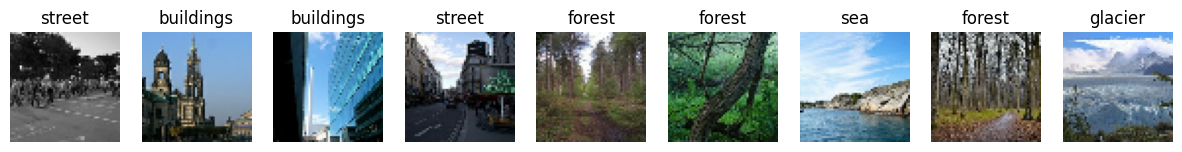

In [ ]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(15, 5))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(1, 9, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

## **Funciones para evaluar modelos**

In [137]:
# Evaluar la pérdida y precisión del modelo
def evaluate_model_performance(model, test_data, training_history):
    """
    Evalúa el rendimiento del modelo en el conjunto de prueba y calcula la
    pérdida y precisión promedio del conjunto de entrenamiento.

    Args:
        - model: Modelo de Keras ya entrenado.
        - test_data: Conjunto de datos de prueba.
        - training_history: Diccionario con el historial de entrenamiento
                          (pérdida y precisión por época).
    """
    test_loss, test_accuracy = model.evaluate(test_data, verbose=0)

    avg_train_loss = np.mean(training_history['loss'][-10:])
    avg_train_accuracy = np.mean(training_history['accuracy'][-10:])

    df = pd.DataFrame(columns=['Train', 'Test'], index=['loss', 'accuracy'])
    df.loc['loss', 'Train'] = avg_train_loss
    df.loc['accuracy', 'Train'] = avg_train_accuracy
    df.loc['loss', 'Test'] = test_loss
    df.loc['accuracy', 'Test'] = test_accuracy

    # Asegurar que todos los valores son numéricos
    df = df.apply(pd.to_numeric)

    # Redondear los valores a dos decimales
    return df.round(2)

In [138]:
# Graficar matriz de confusión o generar reporte de clasificación
def plot_confusion_matrix_or_classification_report(model, test_data, class_names, plot_conf_matrix=True):
    """
    Genera la matriz de confusión o el reporte de clasificación del modelo en el
    conjunto de datos de prueba.

    Args:
        - model: Modelo de Keras ya entrenado.
        - test_data: Conjunto de datos de prueba.
        - class_names: Lista de nombres de clases.
        - plot_conf_matrix: Booleano, True para graficar la matriz de confusión,
                          False para generar el reporte de clasificación.
    """
    all_predictions = []
    all_real_labels = []

    for images, labels in test_data:
        predictions = model.predict(images, verbose=False)
        predicted_classes = np.argmax(predictions, axis=1)
        all_predictions.extend(predicted_classes)
        real_classes = np.argmax(labels.numpy(), axis=1)
        all_real_labels.extend(real_classes)

    if plot_conf_matrix:
        conf_matrix = confusion_matrix(all_real_labels, all_predictions)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=class_names, yticklabels=class_names)
        plt.show()
    else:
        report = classification_report(all_real_labels, all_predictions,
                                       target_names=class_names, output_dict=True)
        df_classification_report = round(pd.DataFrame(report).transpose(), 3)
        return df_classification_report

In [139]:
# Graficar evolución de pérdida y precisión
def plot_training_validation_metrics(history, total_epochs):
    """
    Grafica la evolución de la precisión y pérdida en los conjuntos de entrenamiento
    y validación a lo largo de las épocas.

    Args:
        history: Diccionario con el historial de entrenamiento.
        total_epochs: Número total de épocas en las que se entrenó el modelo.
    """
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    epochs_range = range(total_epochs)

    plt.figure(figsize=(20, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [140]:
# Visualizar predicciones del modelo sobre imágenes de prueba
def visualize_image_predictions(model, class_names, test_data, show_pred_only=False):
    """
    Muestra un conjunto de imágenes del conjunto de prueba con sus clases reales
    y predichas, o solo las predichas si se especifica.

    Args:
        model: Modelo de Keras ya entrenado.
        class_names: Lista de nombres de clases.
        test_data: Conjunto de datos de prueba.
        show_pred_only: Booleano, True para mostrar solo las predicciones,
                        False para mostrar predicciones y clases reales.
    """
    fig, axes = plt.subplots(1, 9, figsize=(16, 4))
    axes = axes.ravel()

    for images, labels in test_data.take(1):
        for i, ax in enumerate(axes):
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis('off')

            image = tf.expand_dims(images[i], axis=0)
            prediction = model.predict(image, verbose=0)
            predicted_class_index = np.argmax(prediction)
            predicted_class = class_names[predicted_class_index]

            if not show_pred_only:
                actual_class = class_names[np.argmax(labels[i])]
                ax.set_title(f"Real: {actual_class}\nPred: {predicted_class}")
            else:
                ax.set_title(f"Pred: {predicted_class}")

        plt.suptitle("Predicciones de imágenes sobre el conjunto de test", y=0.9, fontsize=16)
    plt.show()

## **Modelo de capas densas**

In [73]:
# Construir el modelo
dense_model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(image_height, image_width, 3)),
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(128, activation="relu",
                              kernel_regularizer=tf.keras.regularizers.l2(1e-3)),

        tf.keras.layers.Dropout(0.01),
        tf.keras.layers.Dense(64, activation="relu"),

        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

# Callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')

# Compilación
dense_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [74]:
# Número de épocas de entrenamiento
epoch = 150

# Entrenar el modelo
dense_model_history = dense_model.fit(
    train_prefetch,
    validation_data= val_prefetch,
    epochs=epoch,
    batch_size=batch_size,
    callbacks = [early_stopping]
)

Epoch 1/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.2896 - loss: 29.5931 - val_accuracy: 0.3158 - val_loss: 8.3684
Epoch 2/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3754 - loss: 6.4499 - val_accuracy: 0.3699 - val_loss: 4.4817
Epoch 3/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3793 - loss: 4.9482 - val_accuracy: 0.3877 - val_loss: 3.3734
Epoch 4/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3775 - loss: 3.6775 - val_accuracy: 0.3988 - val_loss: 2.6348
Epoch 5/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3705 - loss: 2.8027 - val_accuracy: 0.3696 - val_loss: 2.2221
Epoch 6/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3669 - loss: 2.2481 - val_accuracy: 0.3778 - val_loss: 1.9889
Epoch 7/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4097 - loss: 2.0097 - val_accuracy: 0.3835 - val_loss: 1.9600
Epoch 8/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4289 - loss: 1.8551 - val_ac

### **Interpretación:**

1.  **Estructura del modelo:** Se eligió una arquitectura sencilla de red neuronal densa con dos capas ocultas de 128 y 64 neuronas respectivamente. La función de activación utilizada en las capas ocultas es ReLU, mientras que en la capa de salida se utilizó Softmax, dado que el problema consiste en una clasificación multiclase de seis categorías.

2.  **Regularización y Dropout:** Se implementó regularización L2 en la primera capa densa para mitigar el sobreajuste observado inicialmente. Además, se incluyó una capa de Dropout con un ratio de 0.01. Aunque este ratio es bajo, se mantuvo así debido a que mayores tasas afectaban negativamente el rendimiento en el conjunto de validación.

3.  **Pruebas con diferentes arquitecturas:** Se experimentó con modelos más complejos, pero el rendimiento no mejoró significativamente. Al reducir la cantidad de neuronas, el desempeño disminuía, mientras que añadir más neuronas tampoco mejoraba la precisión. Por lo tanto, se decidió optar por un modelo más simple que logró el mejor desempeño observado.

4.  **Callback de Early Stopping:** Se añadió un callback de Early Stopping, configurado para detener el entrenamiento si no se observaba una mejora en la precisión de validación en un número determinado de iteraciones.

5.  **Resultados obtenidos:** El modelo logró una precisión del 45%, lo que indica que no fue capaz de aprender adecuadamente los patrones del conjunto de datos. Esto es consistente con las limitaciones de una red densa para procesar información espacial compleja.




### **Guardar el modelo entrenado y dejar disponible su carga**

In [77]:
# Rutas para guardar el modelo entrenado
path_to_save_dense_model = '/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3'

# Guardar el modelo completo
dense_model.save(f'{path_to_save_dense_model}/dense_model.keras')

# Guardar el history en formato JSON
with open(f'{path_to_save_dense_model}/dense_model_history.json', 'w') as f:
    json.dump(dense_model_history.history, f)

In [141]:
# Rutas para cargar el modelo entrenado
path_to_load_dense_model = '/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/dense_model.keras'
path_to_load_history_dense_model = '/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/dense_model_history.json'

# Cargar el modelo guardado
loaded_dense_model = tf.keras.models.load_model(path_to_load_dense_model)

# Cargar el history del modelo guardado
with open(path_to_load_history_dense_model, 'r') as f:
    loaded_dense_model_history = json.load(f)

### **Desempeño del modelo entrenado**

In [79]:
# Comparar la evaluación de train y test
evaluate_model_performance(loaded_dense_model, test, loaded_dense_model_history)

,Train,Test
loss,1.12,1.51
accuracy,0.59,0.48


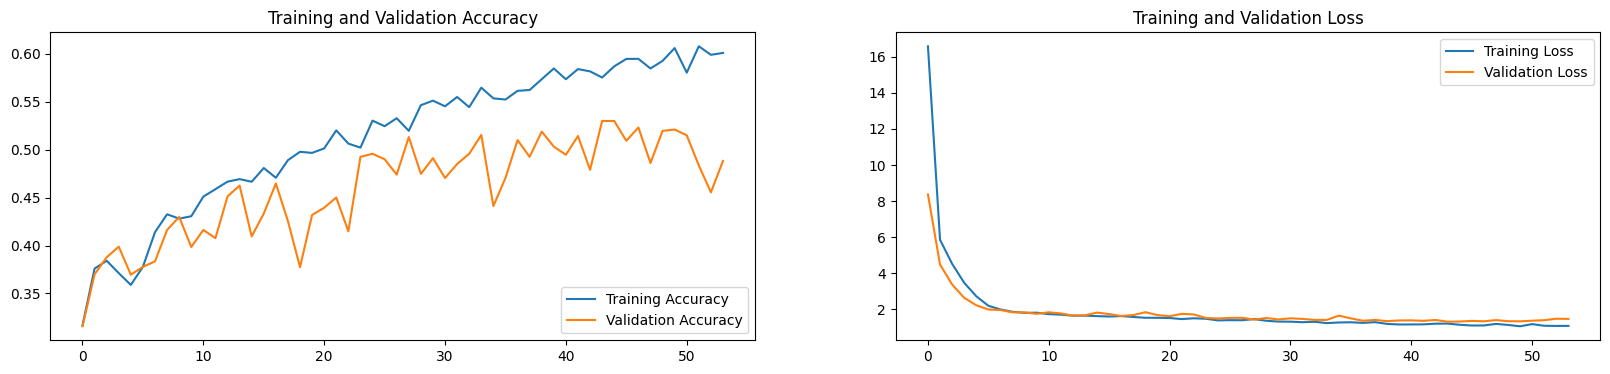

In [143]:
plot_training_validation_metrics(loaded_dense_model_history, len(loaded_dense_model_history['loss']))

In [81]:
# Obtener reporte de clasificación
plot_confusion_matrix_or_classification_report(loaded_dense_model, test, class_names, plot_conf_matrix=False)

,precision,recall,f1-score,support
buildings,0.277,0.483,0.352,437.000
forest,0.667,0.652,0.660,474.000
glacier,0.563,0.515,0.538,553.000
mountain,0.446,0.690,0.542,525.000
sea,0.289,0.043,0.075,510.000
street,0.630,0.479,0.544,501.000
accuracy,0.476,0.476,0.476,0.476
macro avg,0.479,0.477,0.452,3000.000
weighted avg,0.482,0.476,0.453,3000.000


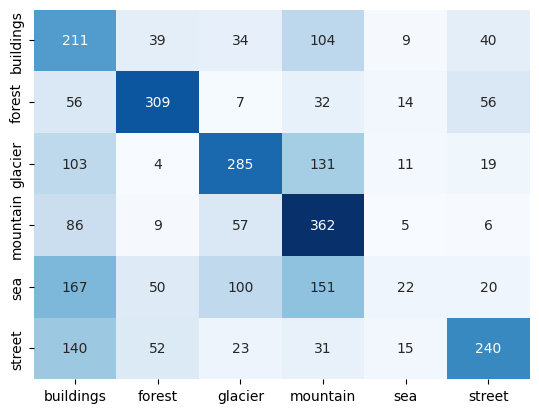

In [82]:
# Graficar matriz de confusión
plot_confusion_matrix_or_classification_report(loaded_dense_model, test, class_names, plot_conf_matrix=True)

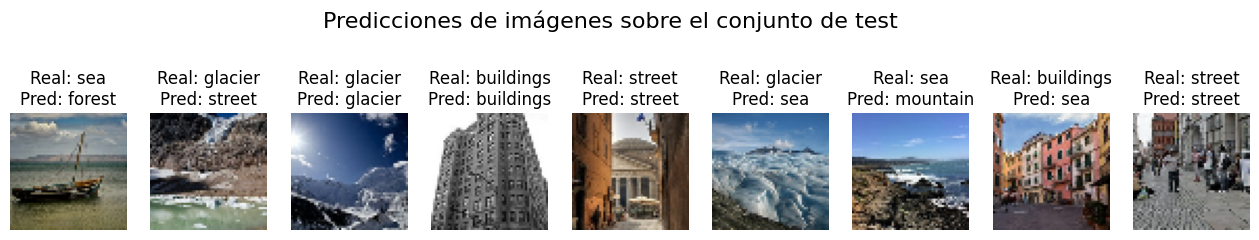

In [ ]:
visualize_image_predictions(loaded_dense_model, class_names, test)

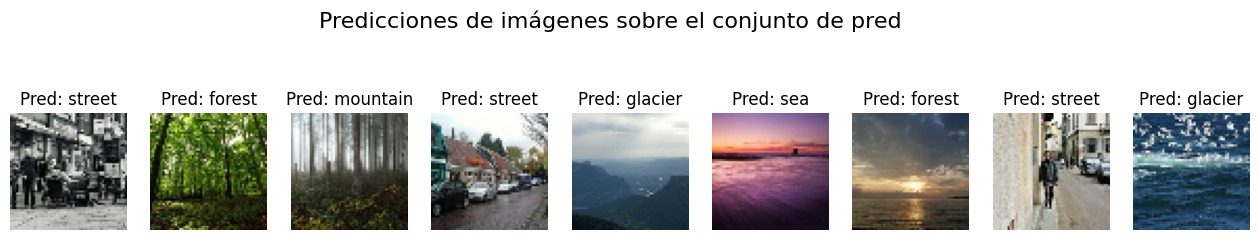

In [ ]:
visualize_image_predictions(loaded_dense_model, class_names, test, pred=True)

### **Interpretación del rendimiento:**

1.   **Comparación de métricas train y test:** El desempeño general del modelo final fue muy bajo, habiendo un pequeño sobreajuste.
2.   **Evolución de la perdida y precisión:** En los gráficos se puede ver como el accuracy de train va a aumentando suvemente hasta estabilizarse en alredeor de 0.6 y seguido de cerca por el de validación con un poco más de ruido.
3.   **Reporte de clasificación y Matriz de confusión:** Se pude notar que 'forest' fue la clase con mejores resultados y 'sea' la que peores métricas obtuvo. En la matriz se puede observar detalladamente las instancias clasificadas correctamente en la diagonal principal.




---

## **Modelo de capas convolucionales y densas**

In [33]:
# Función para construir el modelo
def build_conv_model(input_shape, output_labels, dropout_rate=0.3):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout_rate)(x)

    x = Flatten()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)

    model = tf.keras.Model(inputs=[i], outputs=[x])

    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=['accuracy'])

    return model

In [34]:
print("Building model\n")
conv_model = build_conv_model((image_height, image_width, 3), num_classes)

# Callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=0, mode='max')

# Número de épocas de entrenamiento
epochs = 150

# Entrena el modelo
print("Training model")
conv_history = conv_model.fit(
    train_prefetch,
    validation_data=val_prefetch,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Building model

Training model
Epoch 1/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.3917 - loss: 1.4487 - val_accuracy: 0.6450 - val_loss: 1.0171
Epoch 2/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6279 - loss: 0.9610 - val_accuracy: 0.6671 - val_loss: 0.8755
Epoch 3/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6713 - loss: 0.8743 - val_accuracy: 0.6757 - val_loss: 0.8463
Epoch 4/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7015 - loss: 0.8168 - val_accuracy: 0.7352 - val_loss: 0.7360
Epoch 5/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7147 - loss: 0.7542 - val_accuracy: 0.7548 - val_loss: 0.7113
Epoch 6/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7234 - loss: 0.7442 - val_accuracy: 0.7491 - val_loss: 0.6919
Epoch 7/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7494 - loss: 0.6898 - val_accuracy: 0.7790 - val_loss: 0.6497
Epoch 8/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy:

### **Interpretación:**

1.  **Estructura del modelo:** Se construyó un modelo convolucional con tres capas de convolución, donde los filtros aumentan progresivamente (16, 32 y 64 filtros). Cada capa de convolución está seguida por una activación ReLU y una capa de MaxPooling que reduce las dimensiones espaciales de las imágenes procesadas. Finalmente, se aplanan las características y se pasa a una capa Densa con activación Softmax para la clasificación de las imágenes en múltiples categorías.

2.  **Regularización y Dropout:** Se utilizó una capa de Dropout con una tasa de 0.3 después de cada operación de MaxPooling y tras la capa de Flatten, con el fin de mitigar el sobreajuste.

3.  **Aumento de datos:** Se aplicó aumento de datos mediante la capa RandomFlip, que invierte las imágenes horizontalmente. Esto ayuda a aumentar el tamaño efectivo del conjunto de datos y mejora la robustez del modelo frente a variaciones en la orientación de las imágenes.

4.  **Callback de Early Stopping:** Se implementó un callback de Early Stopping para interrumpir el entrenamiento si la precisión de validación no mejoraba tras 20 épocas. Esto permitió evitar el sobreentrenamiento y reducir el tiempo.

5.  **Resultados obtenidos:** El diseño logró una precisión adecuada, aunque con la posibilidad de mejoras.

### **Guardar el modelo entrenado y dejar disponible su carga**

In [37]:
# Rutas para guardar el modelo entrenado
path_to_save_conv_model = '/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3'

# Guardar el modelo completo
conv_model.save(f'{path_to_save_conv_model}/conv_model.keras')

# Guardar el history en formato JSON
with open(f'{path_to_save_conv_model}/conv_model_history.json', 'w') as f:
    json.dump(conv_history.history, f)

In [59]:
# Rutas para cargar el modelo entrenado
path_to_load_conv_model = '/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/conv_model.keras'
path_to_load_history_conv_model = '/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/conv_model_history.json'

# Cargar el modelo guardado
loaded_conv_model = tf.keras.models.load_model(path_to_load_conv_model)

# Cargar el history del modelo guardado
with open(path_to_load_history_conv_model, 'r') as f:
    loaded_conv_model_history = json.load(f)

### **Desempeño del modelo entrenado**

In [60]:
# Comparar la evaluación de train y test
evaluate_model_performance(loaded_conv_model, test, loaded_conv_model_history)

,Train,Test
loss,0.42,0.57
accuracy,0.85,0.81


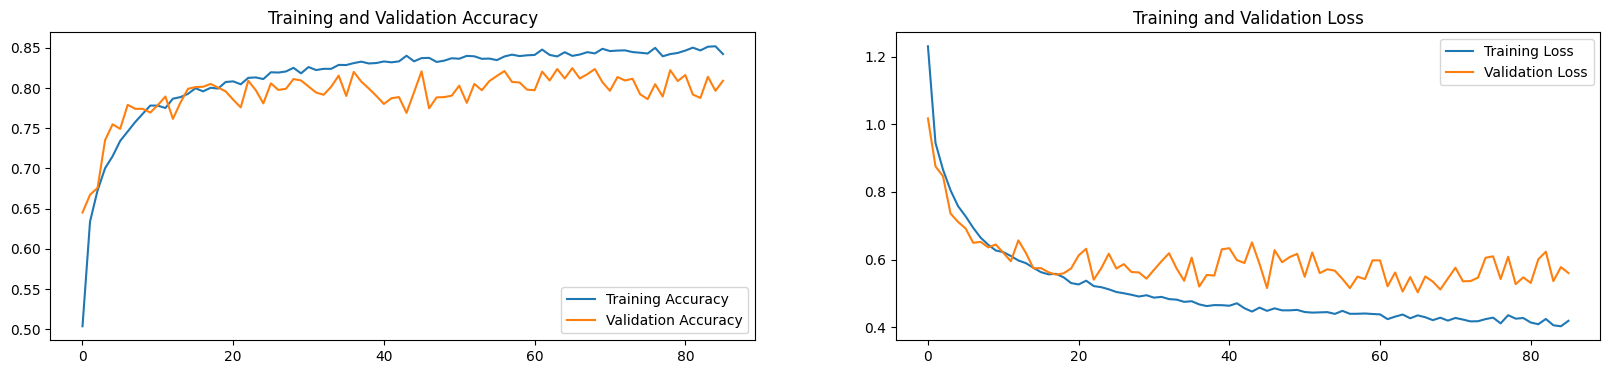

In [54]:
# Evolución de la perdida y precisión
plot_training_validation_metrics(loaded_conv_model_history, len(loaded_conv_model_history['loss']))

In [55]:
# Obtener reporte de clasificación
plot_confusion_matrix_or_classification_report(loaded_conv_model, test, class_names, plot_conf_matrix=False)

,precision,recall,f1-score,support
buildings,0.857,0.684,0.761,437.000
forest,0.739,0.985,0.844,474.000
glacier,0.849,0.743,0.793,553.000
mountain,0.763,0.832,0.796,525.000
sea,0.807,0.859,0.832,510.000
street,0.874,0.731,0.796,501.000
accuracy,0.806,0.806,0.806,0.806
macro avg,0.815,0.806,0.804,3000.000
weighted avg,0.815,0.806,0.804,3000.000


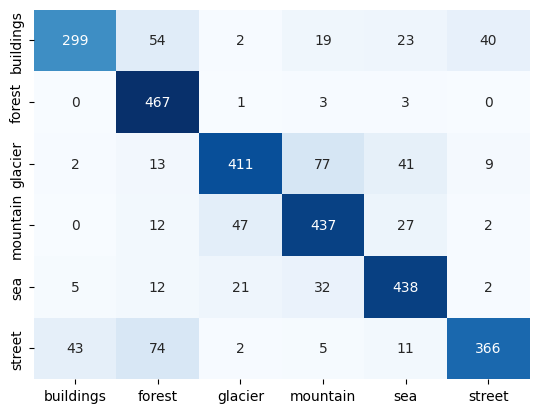

In [56]:
# Graficar matriz de confusión
plot_confusion_matrix_or_classification_report(loaded_conv_model, test, class_names, plot_conf_matrix=True)

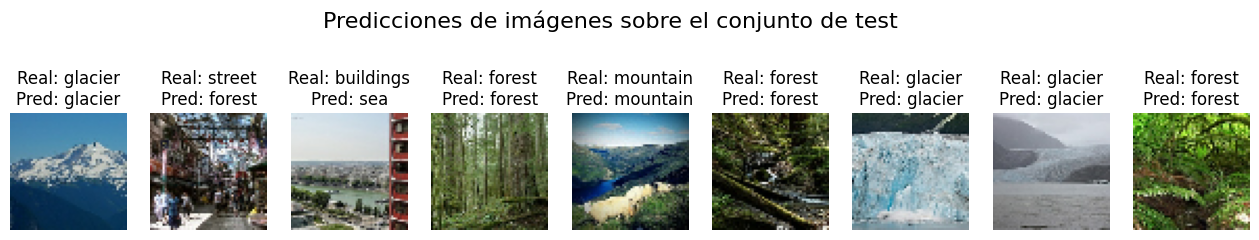

In [57]:
visualize_image_predictions(loaded_conv_model, class_names, test)

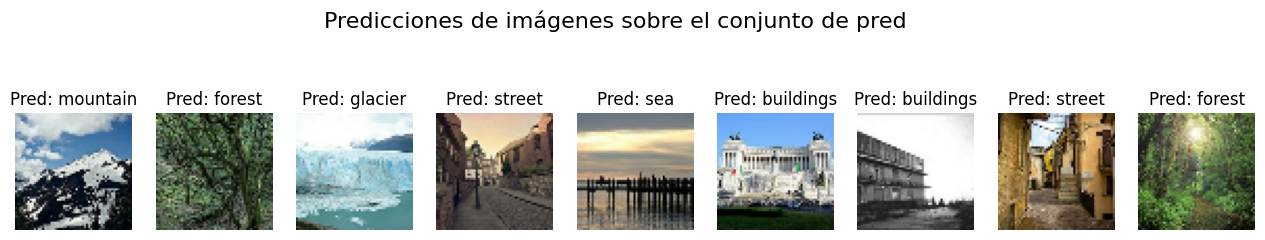

In [58]:
visualize_image_predictions(loaded_conv_model, class_names, test, pred=True)

### **Interpretación del rendimiento:**

1.   **Comparación de métricas train y test:** Las métricas obtenidas en el modelo muestran un buen desepeño en test, con un ligero sobreajuste.
2.   **Evolución de la perdida y precisión:** La precisión y la perdida en ambos datasets evoluciona favorablemnte y se mantienen cercanas.
3.   **Reporte de clasificación y Matriz de confusión:** La detección de clases es generalmente buena, teniendo un menor desempeño en las clases 'buildings' y 'street'.

---
## **Modelo con bloques residuales identidad**

In [83]:
# Definimos un bloque residual
def residual_block_identity(x, filters):
    # Guardar la entrada para la conexión residual
    shortcut = x

    # Primera convolución
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # Segunda convolución
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    # Sumar la entrada a la salida
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

In [93]:
# Definimos una función para construir el modelo
def build_residual_model(input_shape, num_classes, dropout_rate=0.5):
    inputs = Input(shape=input_shape)

    x = Rescaling(1./255)(inputs)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout_rate)(x)

    x = residual_block_identity(x, 32)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout_rate)(x)

    x = residual_block_identity(x, 64)

    x = Flatten()(x)
    x = Dense(128)(x)
    x = Dropout(dropout_rate)(x)
    x = Activation("relu")(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=['accuracy'])

    return model

In [85]:
# Costruir el modelo
residual_model = build_residual_model((image_height, image_width, 3), num_classes)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=0, mode='max')

# Número de épocas de entrenamiento
EPOCHS = 250

# Entrenar el modelo
residual_model_history = residual_model.fit(
    train_prefetch,
    validation_data=val_prefetch,
    epochs=EPOCHS,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Epoch 1/250
351/351 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.2719 - loss: 1.8709 - val_accuracy: 0.3553 - val_loss: 1.5755
Epoch 2/250
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5074 - loss: 1.2308 - val_accuracy: 0.4127 - val_loss: 1.6326
Epoch 3/250
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5634 - loss: 1.0988 - val_accuracy: 0.4170 - val_loss: 1.7162
Epoch 4/250
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5905 - loss: 1.0313 - val_accuracy: 0.4341 - val_loss: 1.6359
Epoch 5/250
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6258 - loss: 0.9599 - val_accuracy: 0.3863 - val_loss: 2.2578
Epoch 6/250
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6404 - loss: 0.9160 - val_accuracy: 0.4779 - val_loss: 1.7794
Epoch 7/250
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6773 - loss: 0.8352 - val_accuracy: 0.5007 - val_loss: 2.1018
Epoch 8/250
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6988 - loss: 0.7812 - val_

### **Interpretación:**

1.  **Estructura del modelo:** Se construyó un modelo basado en bloques residuales, donde las capas convolucionales se benefician de conexiones residuales. Estas conexiones permiten que la entrada original se sume a la salida de las capas convolucionales, mitigando el problema de la degradación del gradiente en redes profundas. Se emplearon dos bloques residuales, cada uno con dos capas convolucionales, lo que permite al modelo aprender características más complejas sin perder información de la entrada original.

2.  **Regularización y Dropout:** Se incluyó una tasa de Dropout de 0.5 después de las capas de MaxPooling para reducir el riesgo de sobreajuste. Esta tasa alta fue efectiva en mejorar la generalización del modelo en comparación con versiones anteriores, donde se utilizaban tasas más bajas.

3.  **Aumento de datos:** Se utilizó una estrategia de aumento de datos que incluyó rotaciones horizontales y verticales aleatorias, así como ajustes de contraste.

4.  **Bloques residuales:** Los bloques residuales permitieron que el modelo aprendiera de manera más eficiente al facilitar la transmisión de gradientes hacia capas anteriores, evitando que el modelo se quede atascado en mínimos locales.

5.  **Callback de Early Stopping:** Se empleó un callback de Early Stopping configurado para detener el entrenamiento si la precisión de validación no mejoraba durante 15 épocas consecutivas.

6.  **Resultados obtenidos:** La implementación de bloques residuales y un mayor aumento de datos permitió al modelo alcanzar una precisión superior en comparación con modelos anteriores sin esta arquitectura.

### **Guardar el modelo entrenado y dejar disponible su carga**

In [95]:
# Rutas para guardar el modelo entrenado
path_to_save_residual_model = '/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3'

# Guardar el modelo completo
residual_model.save(f'{path_to_save_residual_model}/residual_model.keras')

# Guardar el history en formato JSON
with open(f'{path_to_save_residual_model}/residual_model_history.json.json', 'w') as f:
    json.dump(residual_model_history.history, f)

In [96]:
# Rutas para cargar el modelo entrenado
path_to_load_residual_model = '/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/residual_model.keras'
path_to_load_history_residual_model = '/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/residual_model_history.json'

# Cargar el modelo guardado
loaded_residual_model = tf.keras.models.load_model(path_to_load_residual_model)

# Cargar el history del modelo guardado
with open(path_to_load_history_residual_model, 'r') as f:
    loaded_residual_model_history = json.load(f)

### **Desempeño del modelo entrenado**

In [97]:
# Comparar la evaluación de train y test
evaluate_model_performance(loaded_residual_model, test, loaded_residual_model_history)

,Train,Test
loss,0.33,0.57
accuracy,0.88,0.82


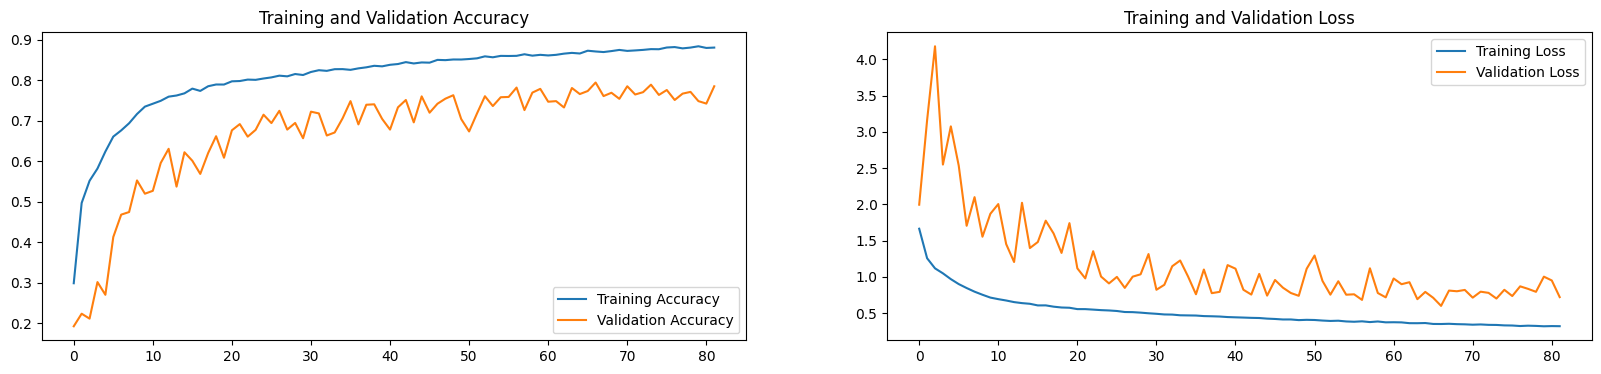

In [98]:
plot_training_validation_metrics(loaded_residual_model_history, len(loaded_residual_model_history['loss']))

In [99]:
# Obtener reporte de clasificación
plot_confusion_matrix_or_classification_report(loaded_residual_model, test, class_names, plot_conf_matrix=False)

,precision,recall,f1-score,support
buildings,0.862,0.730,0.791,437.000
forest,0.841,0.983,0.907,474.000
glacier,0.727,0.828,0.774,553.000
mountain,0.813,0.739,0.774,525.000
sea,0.841,0.808,0.824,510.000
street,0.843,0.806,0.824,501.000
accuracy,0.816,0.816,0.816,0.816
macro avg,0.821,0.816,0.816,3000.000
weighted avg,0.819,0.816,0.814,3000.000


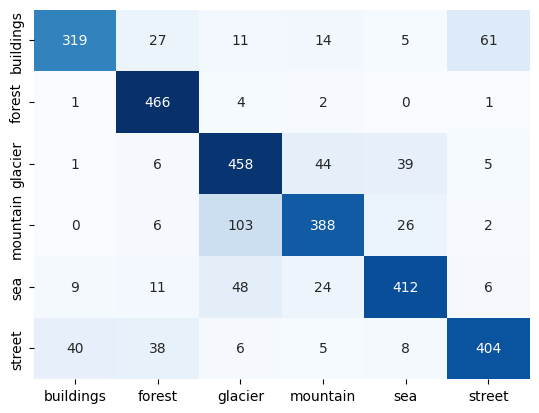

In [100]:
# Graficar matriz de confusión
plot_confusion_matrix_or_classification_report(loaded_residual_model, test, class_names, plot_conf_matrix=True)

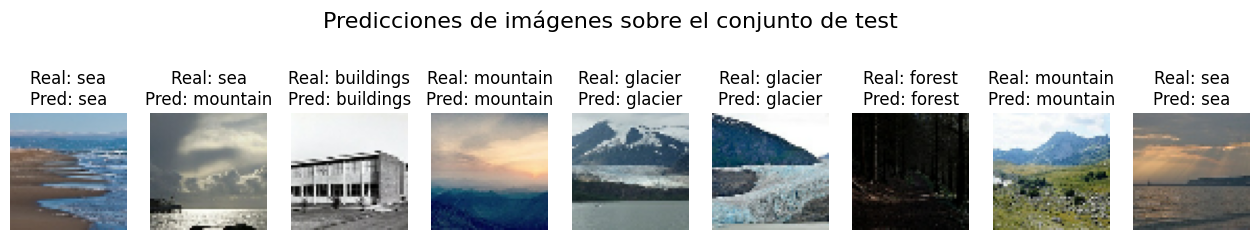

In [ ]:
visualize_image_predictions(loaded_residual_model, class_names, test)

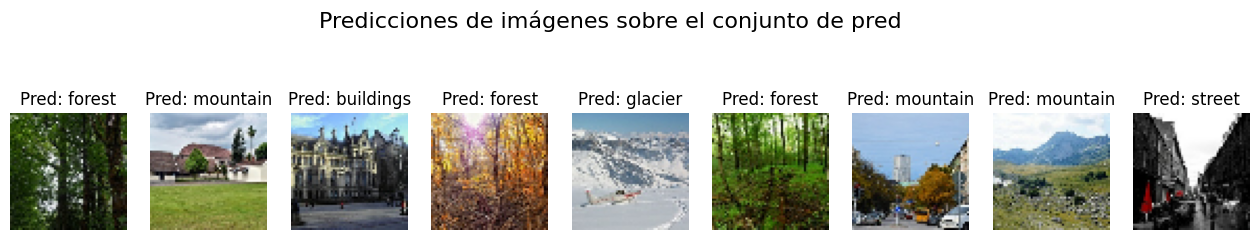

In [ ]:
visualize_image_predictions(loaded_residual_model, class_names, test, pred=True)

### **Interpretación del rendimiento:**

1.   **Comparación de métricas train y test:** El desempeño del modelo es en general bastante bueno, con aproximadamente un 82% de precisión.
2.   **Evolución de la perdida y precisión:** Las métricas evolucionaron sin problemas, en train es más suave y en validación se presenta un ruido que parece empezar a disminuir con el avance de las épocas.
3.   **Reporte de clasificación y Matriz de confusión:** Las clases son etiquetadas con mayor precisión que los modelos anteriores, pero sigue persisitiendo el problema con la clase 'buildings'.

---
## **Modelo con Backbone**



### **EfficentNetB0**

In [148]:
# Construir el modelo
def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    i = Input(shape=input_shape)
    base_model.trainable = False

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomContrast(0.2)(x)

    x = tf.keras.applications.efficientnet.preprocess_input(i)

    x = base_model(x, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(i, x)

    model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

    return model

In [149]:
print("Building model")
backbone_model = build_model((image_height, image_width, 3), num_classes)

# Callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=0, mode='max')

# Número de épocas de entrenamiento
epochs = 100

# Entrena el modelo
backbone_model_history = backbone_model.fit(
    train_prefetch,
    validation_data=val_prefetch,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Building model
Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 46s 71ms/step - accuracy: 0.6463 - loss: 0.9720 - val_accuracy: 0.8275 - val_loss: 0.4836
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8088 - loss: 0.5277 - val_accuracy: 0.8393 - val_loss: 0.4543
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8216 - loss: 0.4872 - val_accuracy: 0.8482 - val_loss: 0.4393
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8272 - loss: 0.4513 - val_accuracy: 0.8493 - val_loss: 0.4417
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8329 - loss: 0.4375 - val_accuracy: 0.8446 - val_loss: 0.4435
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8385 - loss: 0.4310 - val_accuracy: 0.8489 - val_loss: 0.4482
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8404 - loss: 0.4098 - val_accuracy: 0.8439 - val_loss: 0.4460
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8376 - lo

### **Interpretación:**

1.  **Estructura del modelo:** El modelo se construyó utilizando EfficientNetB0 como red base preentrenada en ImageNet, congelando sus pesos. Esto permitió aprovechar características previamente aprendidas en un gran conjunto de datos, lo que redujo el tiempo de entrenamiento y mejoró la generalización.

2.  **Capas adicionales y regularización:** No se utilzaron capas adicionales, ya que no aumentaba la efciencia del modelo de manera considerable. Se utilizó Dropout con una tasa del 0.5 y Batch Normalization para mitigar el sobreajuste y estabilizar el entrenamiento.

3.  **Callback de Early Stopping:** El uso de Early Stopping permitió evitar un sobreentrenamiento al detener el proceso si no se observaba una mejora en la precisión de validación durante 10 épocas consecutivas.

4.  **Resultados obtenidos:** El modelo basado en EfficientNetB0 mostró un rendimiento superior en comparación con arquitecturas diseñadas desde cero. Las características extraídas por la red preentrenada, combinadas con técnicas de regularización, llevaron a una mayor precisión tanto en el entrenamiento como en la validación.

### **Guardar el modelo entrenado y dejar disponible su carga**

In [150]:
# Rutas para guardar el modelo entrenado
path_to_save_backbone_model = '/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3'

# Guardar el modelo completo
backbone_model.save(f'{path_to_save_backbone_model}/backbone_model.keras')

# Guardar el history en formato JSON
with open(f'{path_to_save_backbone_model}/backbone_model_history.json.json', 'w') as f:
    json.dump(backbone_model_history.history, f)

In [151]:
# Rutas para cargar el modelo entrenado
path_to_load_backbone_model = '/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/backbone_model.keras'
path_to_load_history_backbone_model = '/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/backbone_model_history.json'

# Cargar el modelo guardado
loaded_backbone_model = tf.keras.models.load_model(path_to_load_backbone_model)

# Cargar el history del modelo guardado
with open(path_to_load_history_backbone_model, 'r') as f:
    loaded_backbone_model_history = json.load(f)

### **Desempeño del modelo entrenado**

In [152]:
# Comparar la evaluación de train y test
evaluate_model_performance(loaded_backbone_model, test, loaded_backbone_model_history)

,Train,Test
loss,0.40,0.50
accuracy,0.86,0.82


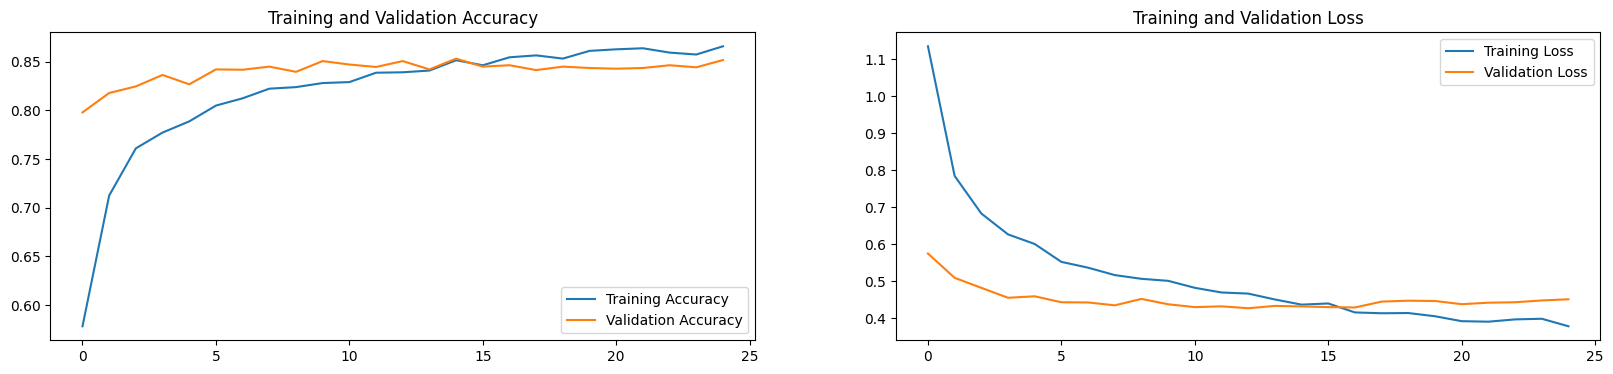

In [153]:
plot_training_validation_metrics(loaded_backbone_model_history, len(loaded_backbone_model_history['loss']))

In [155]:
# Obtener reporte de clasificación
plot_confusion_matrix_or_classification_report(loaded_backbone_model, test, class_names, plot_conf_matrix=False)

,precision,recall,f1-score,support
buildings,0.857,0.824,0.840,437.000
forest,0.973,0.973,0.973,474.000
glacier,0.791,0.684,0.733,553.000
mountain,0.783,0.693,0.735,525.000
sea,0.736,0.908,0.813,510.000
street,0.830,0.884,0.856,501.000
accuracy,0.823,0.823,0.823,0.823
macro avg,0.828,0.828,0.825,3000.000
weighted avg,0.825,0.823,0.821,3000.000


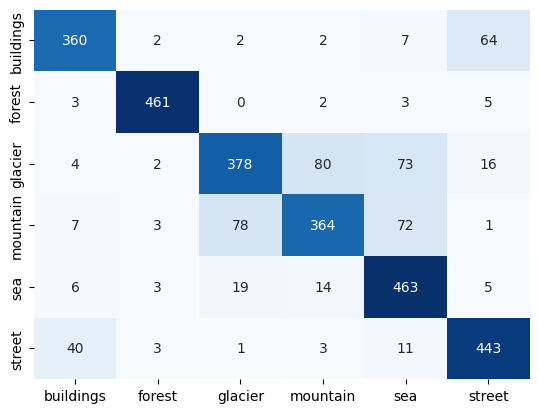

In [159]:
# Graficar matriz de confusión
plot_confusion_matrix_or_classification_report(loaded_backbone_model, test, class_names, plot_conf_matrix=True)

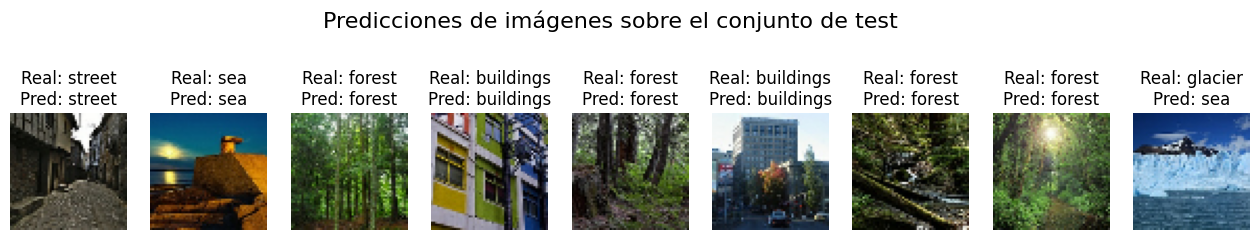

In [72]:
visualize_image_predictions(loaded_backbone_model, class_names, test)

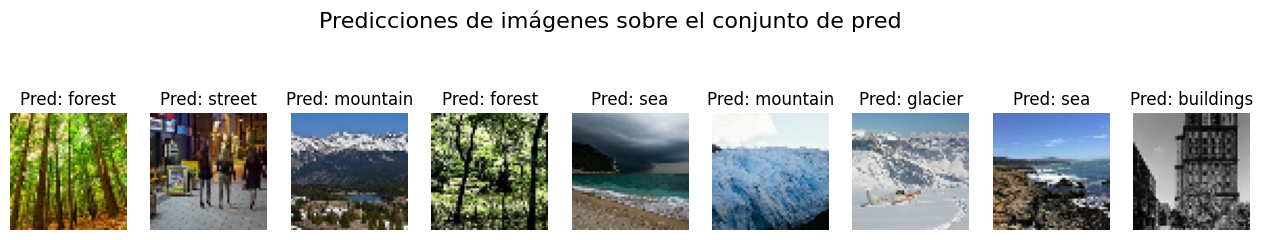

In [ ]:
visualize_image_predictions(loaded_backbone_model, class_names, test, pred=True)

### **Interpretación del rendimiento:**

1.   **Comparación de métricas train y test:** Este modelo fue el que mejor desempeño tuvo, y sigue habiendo un ligero sobreajuste.
2.   **Evolución de la perdida y precisión:** Tanto la perdida y la precisión evolucionaron establemente durante el entrenamiento, destacando, que en el conjunto de validación fueron más estables que en los modelos anteriores.
3.   **Reporte de clasificación y Matriz de confusión:** En este caso la detección de clases fue bastante alta, las clases que tuvieron más problemas 'glacier' y 'mountain'.

## **Conclusión final**

Se probaron diversas arquitecturas para abordar la tarea de clasificación de imágenes. El modelo basado únicamente en capas densas mostró ser limitado en eficiencia, mientras que los modelos convolucional y con bloques residuales lograron un desempeño aceptable mediante arquitecturas relativamente simples. Finalmente, el modelo con un backbone preentrenado fue el que obtuvo los mejores resultados, demostrando que, en este caso, no fue necesario construir una arquitectura compleja para lograr una buena precisión.

Cabe destacar que estos modelos podrían mejorar sus resultados con ajustes adicionales y, potencialmente, con un dataset más amplio, lo que permitiría un mejor aprendizaje de patrones en clases similares que no fueron bien clasificadas, como 'mountain', 'glacier', 'street' y 'buildings'. Esto sugiere que una mayor cantidad de datos podría ayudar a distinguir mejor las características entre estas clases.